# Introdução ao Sensoriamento Remoto e Suas Aplicações


## Descrição

Este notebook faz parte do material complementar da apresentação feita para os alunos da disciplina de Inteligência Artificial, ministrada pelo professor Jessen Vidal no curso de Análise e Desenvolvimento de Sistemas na Faculdade de Tecnologia de São Paulo (FATEC-SJC). Este documento tem como finalidade apresentar a aplicação da arquitetura de rede neural artificial para a classificação de cobertura do solo a partir de imagens do sensor OLI do satélite Landsat 8. Para isso foi usada a técnica de *transfer learning* na arquitetura de rede neural convolucional VGG 19 para identificar plantações de soja na região oeste do estado da Bahia.

### Aviso
Este documento foi redigido somente para fins didáticos, sendo assim, as técnicas aqui utilizadas podem e devem ser evoluídas em caso de sua continuidade com cunho científico.

Os dados utilizados neste notebook podem ser baixados através do link: [https://drive.google.com/file/d/1Qbn5eTiqxlvh_uE7Seu5MqEohZuWA_xh/view?usp=sharing](https://drive.google.com/file/d/1Qbn5eTiqxlvh_uE7Seu5MqEohZuWA_xh/view?usp=sharing)

## Conteúdo

- Carregamento dos dados 
- Análise e visualização dos dados
- Foramatação dos dados para o modelo
- Implementação do modelo
- Compilação do modelo
- Treinamento do modelo
- Avalição do modelo

### Importação das bibliotecas

In [1]:
import os

import geopandas as gpd
import rasterio as rio
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix

from keras.utils import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.applications import VGG19
from keras.utils.vis_utils import plot_model
from PIL import Image

Using TensorFlow backend.
/home/adriano/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/adriano/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/adriano/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/adriano/.local/lib/python3.7/site-packages/tensorflow/py

Constante representando os valores em branco dos dados matriciais

In [2]:
NO_VALUES = -3.3999999521443642e+38

Carregamento dos dados vetoriais contendo as amostras dos dados

In [3]:
gdf = gpd.read_file('./data/test1/buffer05x05.shp')
gdf.head()

,CLASSE PRI,geometry
0,Soja,"POLYGON ((-45.83865 -12.80887, -45.83865 -12.8..."
1,Soja,"POLYGON ((-45.83788 -12.81815, -45.83788 -12.8..."
2,Soja,"POLYGON ((-45.84660 -12.81375, -45.84660 -12.8..."
3,Soja,"POLYGON ((-45.84722 -12.82869, -45.84722 -12.8..."
4,Soja,"POLYGON ((-45.85640 -12.82129, -45.85640 -12.8..."


Carregamento de todas as amostras em dados matriciais

In [4]:
PATH = "./data/test1/buffer/"
all_files = list()
all_tiffs = list()

for root, dirs, files in os.walk(PATH):
    for file in files:
        all_files.append(os.path.join(root, file))

all_files = np.asarray(all_files)
all_tiffs = np.asarray(list(filter(lambda x: x.endswith('.tif'), all_files)))

Visualização da quantidade de amostras por classes

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

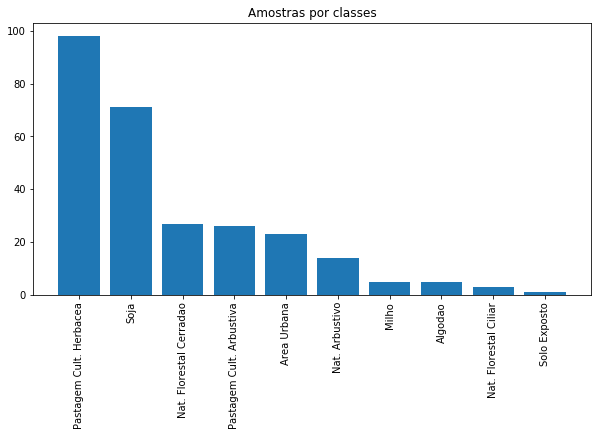

In [5]:
number_classes = {file.split(os.sep)[4] for file in all_tiffs}
number_classes = {key: 0 for key in number_classes}

for file in all_tiffs:
    number_classes[file.split(os.sep)[4]] += 1

number_classes = sorted(number_classes.items(), key=lambda item: item[1], reverse=True)
number_classes = {key: value for key, value in number_classes}
number_classes

plt.figure(figsize=(10, 5))
plt.title("Amostras por classes")
plt.bar(list(number_classes.keys()), list(number_classes.values()))
plt.xticks(rotation=90)
# sorted(number_classes, key=number_classes.get, reverse=True)

Visualização das 5 bandas selecionadas em cada uma das classes

/home/adriano/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


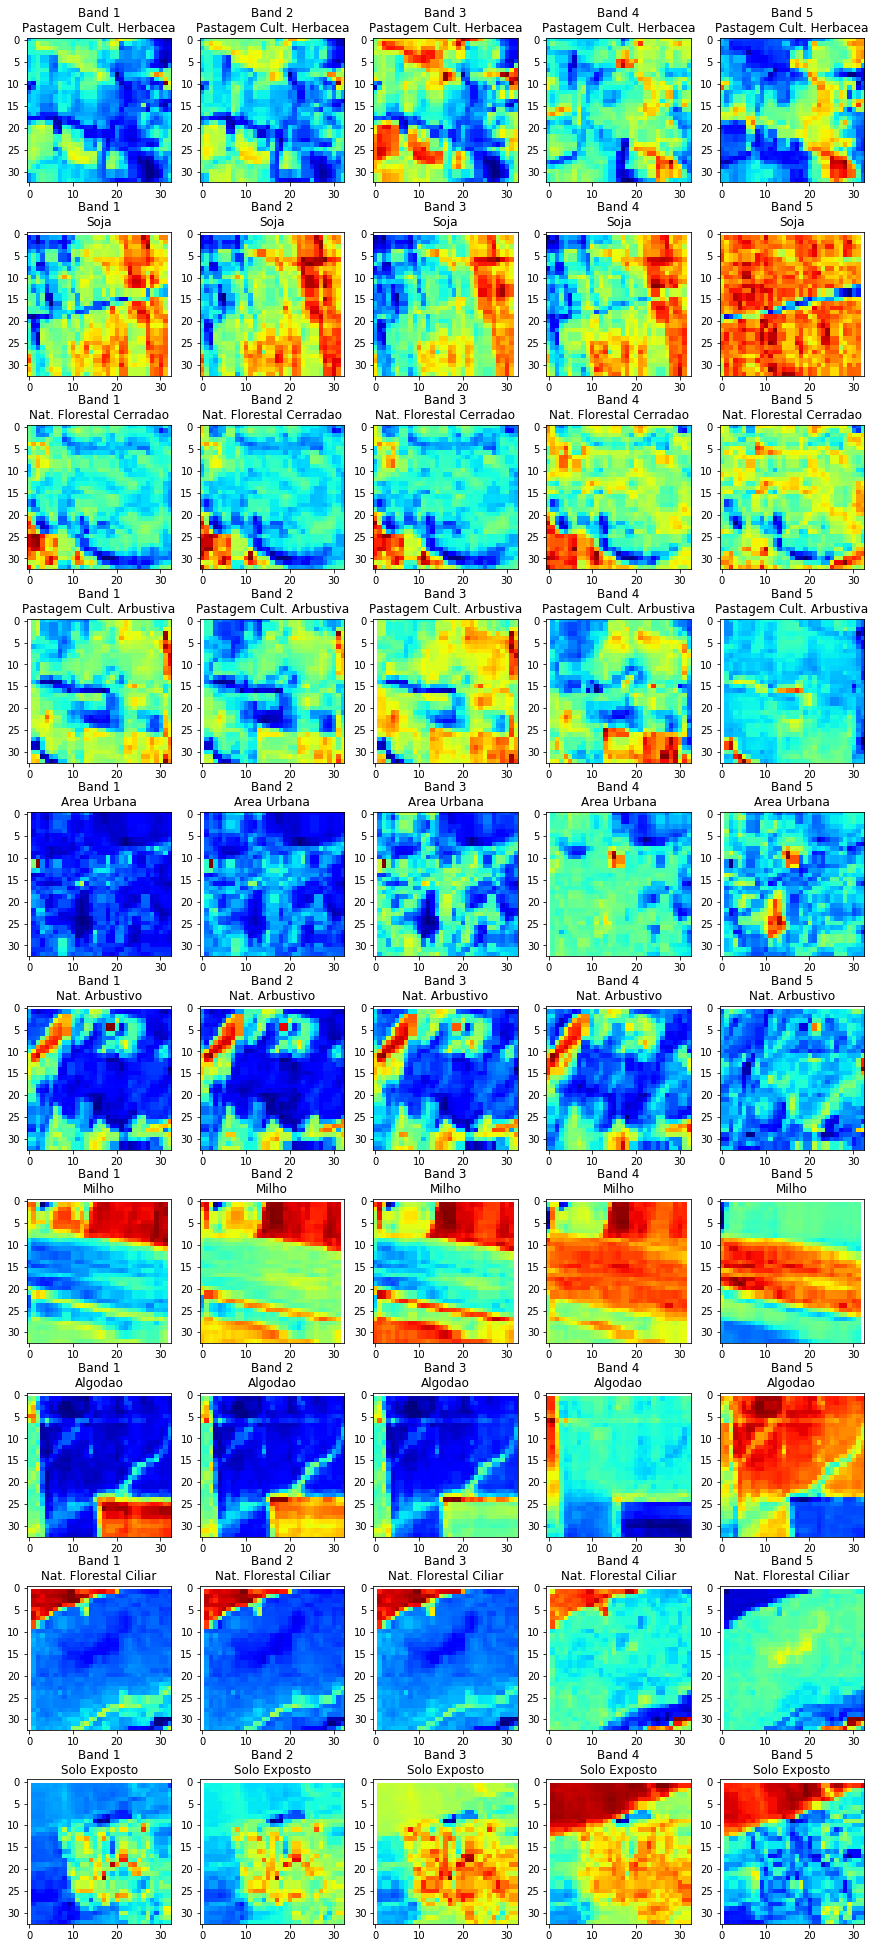

In [6]:
fig, ax = plt.subplots(10, 5, figsize=(15, 35))
idx = -1
linked_files = dict()
for i in range(10):
    idx+=1
    classe = list(number_classes.keys())[idx]
    temp = list(filter(lambda x: x.split(os.sep)[-4] == classe, all_tiffs))
    linked_files[classe] = temp
    nc = xr.open_rasterio(temp[0])
    for j in range(5):
        data = nc[j].data
        data[data == nc.nodatavals[0]] = np.nanmean(nc[j].data)
        ax[i][j].set_title('Band %d\n%s'%(j+1, classe))
        ax[i][j].imshow(data, cmap='jet')
# plt.savefig('landcovers.png', dpi=100)

Separação de duas classes para treinar o modelo

In [7]:
def select_class(filename, classe):
    filename = filename.split('/')[-1]
    return filename.split('_')[0] == classe

true_color_files = "./data/area_test/input/true_color/"
files = [os.path.join(true_color_files, file) for file in os.listdir(true_color_files)]
c1 = list(filter(lambda x: select_class(x, 'Soja'), files))
c2 = list(filter(lambda x: select_class(x, 'Pastagem Cult. Herbacea'), files))


Carregamento das matrizes processadas em *true color* e suas respectivas classes para a criação do modelo. 

In [8]:
X = list()
Y = list()

for file in c1:
    data = xr.open_rasterio(file)
    NO = np.unique(data.nodatavals)
    temp = list()
    for j in range(data.shape[0]):
        aux = data[j].data
        aux[aux == NO] = np.nan
        aux[np.isnan(aux)] = 0#np.nanmean(aux)
        temp.append(aux)
    X.append(temp)
    Y.append(0)

for file in c2:
    data = xr.open_rasterio(file)
    NO = np.unique(data.nodatavals)
    temp = list()
    for j in range(data.shape[0]):
        aux = data[j].data
        aux[aux == NO] = np.nan
        aux[np.isnan(aux)] = 0#np.nanmean(aux)
        temp.append(aux)
    X.append(temp)
    Y.append(1)
    
X = np.asarray(X)
Y = np.asarray(Y)

Categorização dos dados de saída.

In [9]:
Y = np_utils.to_categorical(Y)

Redefinição do shape dos dados de entrada.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2)

shape = X_train.shape
X_trainr = X_train.reshape((shape[0], shape[2], shape[3], shape[1]))

shape = X_test.shape
X_testr = X_test.reshape((shape[0], shape[2], shape[3], shape[1]))

shape = X_trainr.shape
shape

(135, 33, 33, 3)

Importação da arquitetura VGG 19 e dos pesos atualizados com o treinamento com a base de dados imagenet.

In [11]:
base_net = VGG19(weights='imagenet', include_top=False, input_shape=(X_testr.shape[1], X_testr.shape[2], 
                                                                  X_testr.shape[3]))
base_net.trainable = True
set_trainable = False
for layer in base_net.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
base_net.summary()

W0701 18:46:30.668457 140577278007104 deprecation.py:506] From /home/adriano/.local/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 33, 33, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 33, 33, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 33, 33, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

Acomplamento da arquitetura VGG 19 em um modelo customizado.

In [12]:
model = models.Sequential()
model.add(base_net)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(2, activation='softmax'))

W0701 18:46:31.499420 140577278007104 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 1, 1, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2

Compilação do modelo, utilizando a função de perda *binary cross entropy*.

In [14]:
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

Treinamento do modelo

In [19]:
history = model.fit(X_trainr, y_train, batch_size=16, validation_data=(X_testr, y_test), epochs=100)

Train on 135 samples, validate on 34 samples
Epoch 1/100
135/135 [==============================] - 1s 9ms/sample - loss: 8.1970e-04 - acc: 1.0000 - val_loss: 0.0236 - val_acc: 0.9706
Epoch 2/100
135/135 [==============================] - 1s 9ms/sample - loss: 0.1171 - acc: 0.9630 - val_loss: 0.0040 - val_acc: 1.0000
Epoch 3/100
135/135 [==============================] - 1s 10ms/sample - loss: 0.0548 - acc: 0.9852 - val_loss: 0.1258 - val_acc: 0.9706
Epoch 4/100
135/135 [==============================] - 1s 10ms/sample - loss: 0.0376 - acc: 0.9852 - val_loss: 0.0091 - val_acc: 1.0000
Epoch 5/100
135/135 [==============================] - 1s 9ms/sample - loss: 0.0039 - acc: 1.0000 - val_loss: 0.0403 - val_acc: 0.9706
Epoch 6/100
135/135 [==============================] - 2s 12ms/sample - loss: 0.0028 - acc: 1.0000 - val_loss: 2.2675 - val_acc: 0.8529
Epoch 7/100
135/135 [==============================] - 2s 14ms/sample - loss: 5.6629e-04 - acc: 1.0000 - val_loss: 2.4431 - val_acc: 0.794

Avaliação das curvas de convergência do modelo durante o treinamento.

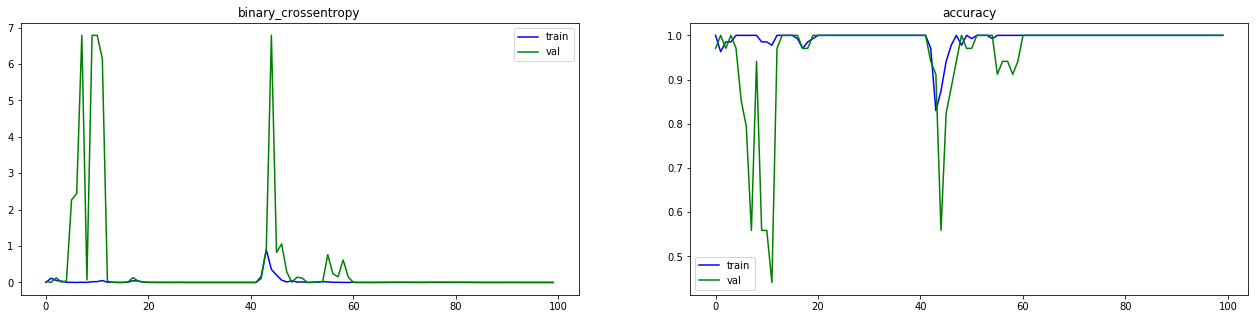

In [20]:
val_loss, loss = history.history['val_loss'], history.history['loss']
val_acc, acc = history.history['val_acc'], history.history['acc']
    
fig, ax = plt.subplots(1, 2, figsize=(22, 5))
ax[0].plot(loss, label='train', color='blue')
ax[0].plot(val_loss, label='val', color='green')
ax[0].legend()
ax[0].set_title('binary_crossentropy')

ax[1].plot(acc, label='train', color='blue')
ax[1].plot(val_acc, label='val', color='green')
ax[1].legend()
ax[1].set_title('accuracy')

plt.savefig('curves.png', dpi=100, \
           bbox_inches='tight', transparent="False", pad_inches=0.1)

Obtenção de algumas métricas de avaliação do modelo

In [21]:
y_pred = model.predict(X_testr)
pred = np.argmax(y_pred, axis=1)
real = np.argmax(y_test, axis=1)

cm = confusion_matrix(real, pred)

total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print("Acurácia: {:.4f}".format(acc))
print("Sensitividade: {:.4f}".format(sensitivity))
print("Especificidade: {:.4f}".format(specificity))


Acurácia: 1.0000
Sensitividade: 1.0000
Especificidade: 1.0000


Matriz de confusão das availiações do modelo.

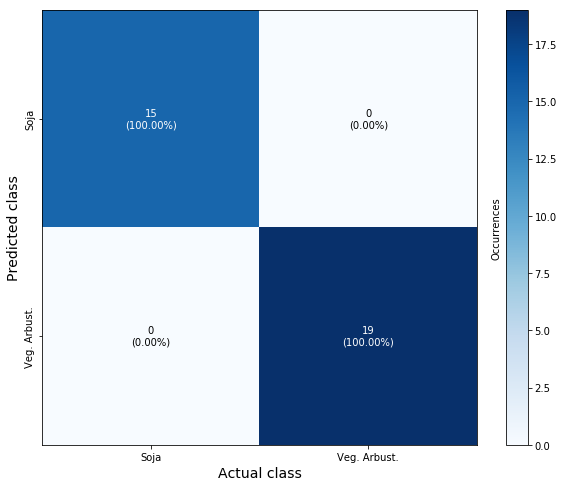

In [22]:
figsize = (15, 8)
fig, ax = plt.subplots(1, 1, figsize=figsize)

cmap = plt.cm.Blues
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.4)

total_samples = cm.sum(axis=1)[:, np.newaxis]
normed_conf_mat = cm.astype('float') / total_samples
labels = ['Soja', 'Veg. Arbust.']
label_font = dict(fontweight='normal', size=14)
title_font = dict(fontweight='normal', size=18)

matshow = ax.matshow(cm, cmap=cmap)
cb = plt.colorbar(matshow, cax=cax, orientation='vertical')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        cell_text = str(cm[i, j])
        cell_text += '\n(%.2f%%)' % (normed_conf_mat[i, j] * 100)
        ax.text(x=j,
                y=i,
                s=cell_text,
                va='center',
                ha='center',
                color="white" if normed_conf_mat[i, j] > 0.5 else "black")

ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels, rotation=90, va='center')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

#     ax.set_title('Matriz de confusão para %d testes'%((n*2)*0.2), fontdict=title_font)
ax.set_xlabel('Actual class', fontdict=label_font)
ax.set_ylabel('Predicted class', fontdict=label_font)
cb.ax.set_ylabel('Occurrences', va='center', rotation=-270, labelpad=-60)

plt.savefig('confusion_matrix_blue.png', dpi=100, \
           bbox_inches='tight', transparent="False", pad_inches=0.1)